## Tree-based Ensembles Training
- Random Forest
- Gradient Boosting
- XGBoost

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, ConfusionMatrixDisplay,
    confusion_matrix, roc_curve, roc_auc_score, make_scorer,
    classification_report, log_loss
)
import xgboost as xgb

import optuna
sns.set_theme(context='notebook', style='ticks')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [30]:
df = pd.read_csv('../data/processed/pulsar_processed.csv')
df.head()

,PC1,PC2,PC3,PC4,PC5,target_class
0,-1.278849,1.273133,0.016213,0.662102,0.577362,0
1,-1.020553,0.201162,0.670478,1.605779,-0.390326,0
2,0.188289,-0.432114,-0.979766,-0.519232,-0.305346,0
3,-1.015466,1.469881,-0.018832,0.938386,0.495189,0
4,-0.822626,-2.123651,0.407953,-0.380922,-0.654083,0


In [31]:
X = df.drop(columns=['target_class'])
y = df['target_class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

## Random Forest

### Baseline Model

In [32]:
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

rf_baseline.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [33]:
y_pred = rf_baseline.predict(X_test)

y_pred_proba = rf_baseline.predict_proba(X_test)[:, 1]

In [34]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3252
           1       0.94      0.85      0.89       328

    accuracy                           0.98      3580
   macro avg       0.96      0.92      0.94      3580
weighted avg       0.98      0.98      0.98      3580



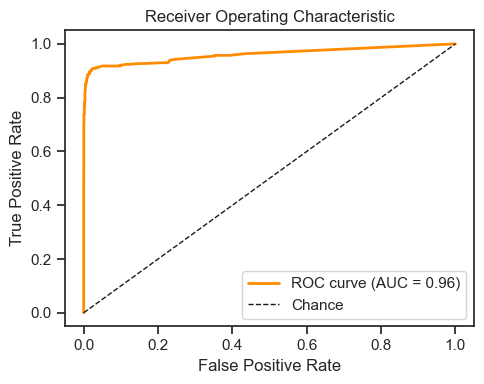

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

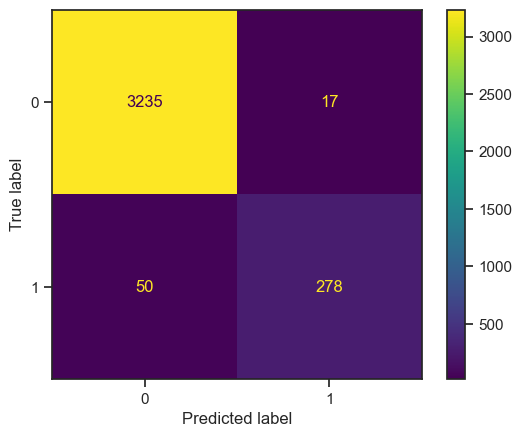

In [36]:
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(cm)
fig.plot()

In [37]:
print(f'Log  Loss: {log_loss(y_test, y_pred_proba):.4f}')

Log  Loss: 0.1773


### Hyperparameter Tuning with GridSearch and CV

The Cross Validation concept allow us to work with 3 sets: training, validation and testing. That's why we use only the training set to find the best hyperparameters. So, when we finish this process, we can evaluate the model with the test set that was never used before.

In [38]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

In [39]:
rf_model_cv = RandomForestClassifier(class_weight='balanced', random_state=42)
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=rf_model_cv,
    param_grid=param_grid,
    scoring=scorer,
    cv=kfolds,
    n_jobs=-1,
    verbose=1
)

In [40]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 20, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,"make_scorer(f..., pos_label=1)"
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [42]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f'Best params: {best_params}')
best_score = grid_search.best_score_
print(f'Best cross-validated F1 score: {best_score:.4f}')

Best params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validated F1 score: 0.8713


In [43]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3252
           1       0.92      0.86      0.89       328

    accuracy                           0.98      3580
   macro avg       0.96      0.93      0.94      3580
weighted avg       0.98      0.98      0.98      3580



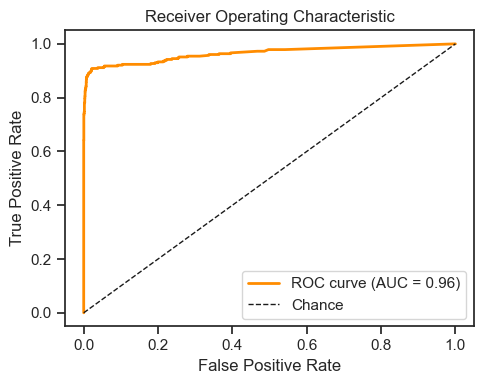

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

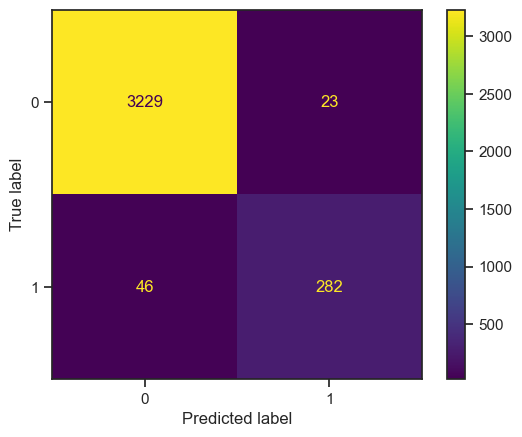

In [45]:
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(cm)
fig.plot()